In [1]:
import os, subprocess, sys, time, itertools, shutil
from typing import List, Tuple

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_theme()

In [2]:
base_dir = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
seq_db = os.path.join(base_dir, "input", "sequence_db")

#Path to the benchmark databases
db_len_path = os.path.join(base_dir, "input", "sequence_db", "BM_db_e6")
db_nb_path = os.path.join(base_dir, "input", "sequence_db", "BM_db_100")

#Path to the modules
db_code = os.path.join(base_dir, "code")

# Computation Time Benchmarking

## 1 - Signature computation (compute_signature.py)

### 1.1 - Depending on the number of input genome files

In [30]:
def compute_signatures(input_db : str, metric : int, code_dir : str = db_code):
    """ Compute the signature of the genomes in the input database"""
    os.chdir(code_dir)

    subprocess.run(
        f"python -m compute_signatures {input_db} -m {metric}", shell=True
        )
    
    return 0

def rm_tmp(seq_db : str):
    for folder in os.listdir(seq_db):
        if folder.startswith('tmp_'):
            shutil.rmtree(os.path.join(seq_db, folder))


In [12]:
def create_tmp_db(input_db: str, parameters: Tuple[int, int]) -> str:
    """Create a temporary truncated database"""
    realpath_input_db = os.path.join(seq_db, input_db)
    name_new_input_db = f'tmp_{input_db}_{parameters[1]}'
    destination_path = os.path.join(seq_db, name_new_input_db)

    # Créez le répertoire parent destination
    os.makedirs(destination_path, exist_ok=True)

    # Limitez la liste des sous-dossiers/fichiers à copier
    items_to_copy = os.listdir(realpath_input_db)[:parameters[1]]

    for item in items_to_copy:
        source_path = os.path.join(realpath_input_db, item)
        dest_path = os.path.join(destination_path, item)

        if os.path.isdir(source_path):
            shutil.copytree(source_path, dest_path)
        else:
            shutil.copy2(source_path, dest_path)

    return name_new_input_db

def grid_search(input_db : str):
    couples_metric = { 
            "Lp_distance" : 0,
            "Chi-squared_distance" : 1,
            "KL_divergence" : 2,
            "Convolution" : 3
        }

    list_nb_files = np.linspace(2, 20, 10).astype(int).tolist()
    param_list = sorted(list(itertools.product(list(couples_metric.values()), list_nb_files)), key=lambda x : x[1])
    result_frame = pd.DataFrame(columns=list_nb_files, index=couples_metric.keys())

    for parameters in param_list:
        if os.path.exists(os.path.join(seq_db, f'tmp_{input_db}_{parameters[1]}')):
            pass
        else:
            try:
                shutil.rmtree(tmp_input_db)
            except Exception:
                tmp_input_db = create_tmp_db(input_db, parameters)

        start_time = time.time()
        compute_signatures(tmp_input_db, parameters[0])
        
        cp_time = time.time()-start_time
        result_frame.iat[parameters[0], list_nb_files.index(parameters[1])] = cp_time

    rm_tmp(seq_db)
    return result_frame

time_stamp = grid_search("BM_db_20")
time_stamp


(0, 2)
(1, 2)
(2, 2)
(3, 2)
(0, 4)
(1, 4)
(2, 4)
(3, 4)
(0, 6)
(1, 6)
(2, 6)
(3, 6)
(0, 8)
(1, 8)
(2, 8)
(3, 8)
(0, 10)
(1, 10)
(2, 10)
(3, 10)
(0, 12)
(1, 12)
(2, 12)
(3, 12)
(0, 14)
(1, 14)
(2, 14)
(3, 14)
(0, 16)
(1, 16)
(2, 16)
(3, 16)
(0, 18)
(1, 18)
(2, 18)
(3, 18)
(0, 20)
(1, 20)
(2, 20)
(3, 20)


,2,4,6,8,10,12,14,16,18,20
Chi-squared_distance,26.580882,59.093715,89.918875,106.267102,137.538974,207.078923,237.7593,248.138419,271.577975,291.418886
Lp_distance,30.427783,59.276635,90.154427,105.005909,142.718573,214.904505,226.699422,254.511503,272.838622,295.726352
KL_divergence,34.640367,88.302151,133.770016,165.59893,256.345879,352.177351,344.636033,383.445552,410.204208,449.605498
Convolution,17.665951,49.976062,72.916269,92.87298,147.412949,199.997565,190.084384,207.753009,228.682841,238.405616


c:\Users\matte\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\matte\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


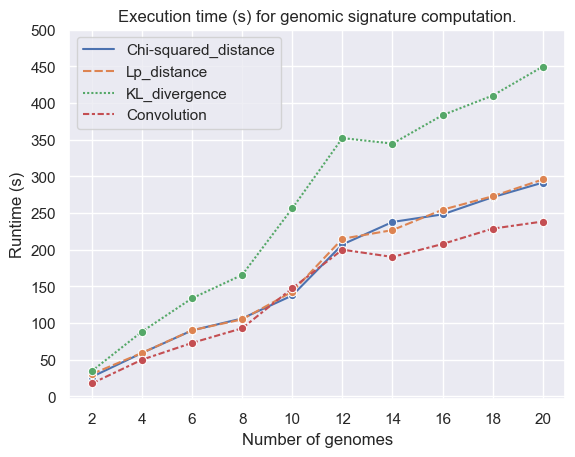

In [24]:
def display_cp_time(df_time : pd.DataFrame):
    sns.lineplot(df_time.T, marker='o')
    plt.title("Execution time (s) for genomic signature computation.")
    plt.xticks(np.linspace(2, 20, 10).astype(int))
    plt.yticks(np.linspace(0, 500, 11))
    plt.ylabel("Runtime (s)")
    plt.xlabel("Number of genomes")
    plt.show()

display_cp_time(time_stamp)

### 1.2 - Depending on the length of input genome files

In [37]:
def prepare_tmp_list(seq_db : str):
    """select wanted folders"""
    return [folder for folder in os.listdir(seq_db) if folder.startswith('tmp_')]

def grid_search_len():
    couples_metric = { 
        "Lp_distance" : 0,
        "Chi-squared_distance" : 1,
        "KL_divergence" : 2,
        "Convolution" : 3
    }
    folder_list = prepare_tmp_list(seq_db)
    result_df = pd.DataFrame(index = list(couples_metric.keys()), columns=folder_list)
    param_list = sorted(list(itertools.product(list(couples_metric.values()), folder_list)), key=lambda x : x[1])

    for metric, folder in param_list:
        print(folder)

        start_time = time.time()
        compute_signatures(folder, metric)
        result_df.iat[metric, folder_list.index(folder)] = (time.time()-start_time)/5

    rm_tmp(seq_db)
    return result_df

result_df = grid_search_len()
result_df

tmp_BM_db_1000000.0
tmp_BM_db_1000000.0
tmp_BM_db_1000000.0
tmp_BM_db_1000000.0
tmp_BM_db_10000000.0
tmp_BM_db_10000000.0
tmp_BM_db_10000000.0
tmp_BM_db_10000000.0
tmp_BM_db_3000000.0
tmp_BM_db_3000000.0
tmp_BM_db_3000000.0
tmp_BM_db_3000000.0
tmp_BM_db_500000.0
tmp_BM_db_500000.0
tmp_BM_db_500000.0
tmp_BM_db_500000.0
tmp_BM_db_5000000.0
tmp_BM_db_5000000.0
tmp_BM_db_5000000.0
tmp_BM_db_5000000.0
tmp_BM_db_7000000.0
tmp_BM_db_7000000.0
tmp_BM_db_7000000.0
tmp_BM_db_7000000.0


,tmp_BM_db_1000000.0,tmp_BM_db_10000000.0,tmp_BM_db_3000000.0,tmp_BM_db_500000.0,tmp_BM_db_5000000.0,tmp_BM_db_7000000.0
Lp_distance,4.278662,33.752915,9.160786,2.008754,15.871486,23.077004
Chi-squared_distance,3.427048,32.3449,9.226846,1.968796,16.495329,22.974936
KL_divergence,5.527218,48.928478,15.214933,3.220735,26.60237,38.650219
Convolution,5.592297,26.292308,7.759008,1.828629,14.003857,19.630879


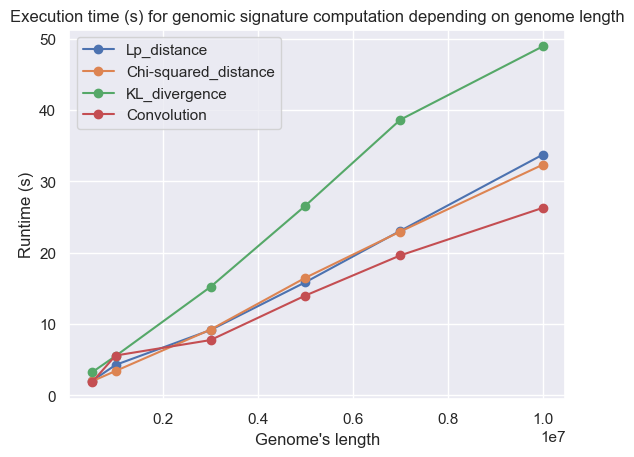

In [39]:
def display_cp_time(df_time : pd.DataFrame):
    new_order = sorted(df_time, key=lambda x : float(x.split('_')[3]))
    df_time = df_time.reindex(columns = new_order)
    genome_sizes = [float(name.split('_')[-1].replace('.0', '')) for name in df_time.columns]
    
    for i, index in enumerate(df_time.index):
        plt.plot(genome_sizes,df_time.iloc[i, :],  label=index, marker="o")

    plt.title("Execution time (s) for genomic signature computation depending on genome length")
    plt.ylabel("Runtime (s)")
    plt.xlabel("Genome's length")
    plt.legend()
    plt.show()

display_cp_time(result_df)